In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np

# Loading the training and test datasets
train_data = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')

In [2]:
# Prepare features (X) and target (y)
X = train_data.drop(['Price', 'id'], axis=1)  
y = train_data['Price']

In [3]:
# Handle missing data
numeric_features = ['Compartments', 'Weight Capacity (kg)']
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

categorical_features = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_features] = categorical_imputer.fit_transform(X[categorical_features])

# One hot encoding categorical data
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_categorical_data = encoder.fit_transform(X[categorical_features])

encoded_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_features))
X = X.drop(categorical_features, axis=1)
X = pd.concat([X, encoded_df], axis=1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
#Feature Engineering

# 1. Price_per_kg 
X['Price_per_kg'] = y / X['Weight Capacity (kg)']

# 2. Density 
X['Density'] = X['Weight Capacity (kg)'] / (X['Compartments'] + 1)

# 3. Premium_Brand
premium_brands_columns = [col for col in encoded_df.columns if 'Brand_' in col]
premium_brands = ['Brand_Samsonite', 'Brand_Tumi', 'Brand_Rimowa']
print(f"Premium brands columns found: {premium_brands_columns}")

X['Premium_Brand'] = X[premium_brands_columns].sum(axis=1)
X['Premium_Brand'] = X['Premium_Brand'].apply(lambda x: 1 if x > 0 else 0)

# 4. Feature_Score 
X['Feature_Score'] = (X['Laptop Compartment_Yes'] == 1).astype(int) + \
                     (X['Waterproof_Yes'] == 1).astype(int) + \
                     (X['Style_Backpack'] == 1).astype(int)

# 5. Brand_Price_Ratio 
brand_price_mean = train_data.groupby('Brand')['Price'].mean()

def calculate_brand_price_ratio(row):
    active_brand_column = [col for col in row.index if col.startswith('Brand_') and row[col] == 1]
    if active_brand_column:
        active_brand = active_brand_column[0].replace('Brand_', '')
        if active_brand in brand_price_mean.index:
            return brand_price_mean[active_brand] / row['Price_per_kg']
    return np.nan 


X['Brand_Price_Ratio'] = X.apply(calculate_brand_price_ratio, axis=1)
X['Brand_Price_Ratio'] = X['Brand_Price_Ratio'].fillna(X['Brand_Price_Ratio'].mean())

print("NaN values before splitting:\n", X.isna().sum())


Premium brands columns found: ['Brand_Adidas', 'Brand_Jansport', 'Brand_Nike', 'Brand_Puma', 'Brand_Under Armour']
NaN values before splitting:
 Compartments              0
Weight Capacity (kg)      0
Brand_Adidas              0
Brand_Jansport            0
Brand_Nike                0
Brand_Puma                0
Brand_Under Armour        0
Material_Canvas           0
Material_Leather          0
Material_Nylon            0
Material_Polyester        0
Size_Large                0
Size_Medium               0
Size_Small                0
Laptop Compartment_No     0
Laptop Compartment_Yes    0
Waterproof_No             0
Waterproof_Yes            0
Style_Backpack            0
Style_Messenger           0
Style_Tote                0
Color_Black               0
Color_Blue                0
Color_Gray                0
Color_Green               0
Color_Pink                0
Color_Red                 0
Price_per_kg              0
Density                   0
Premium_Brand             0
Feature_Score  

In [5]:
# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r_2 = r2_score(y_true, y_pred)
    return mse, mae, r_2

#Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


mse_rf, mae_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
print(f"Random Forest:")
print(f"  Mean Squared Error: {mse_rf}")
print(f"  Mean Absolute Error: {mae_rf}")
print(f"  R-squared: {r2_rf}")

Random Forest:
  Mean Squared Error: 0.019933514420920704
  Mean Absolute Error: 0.09747946070166676
  R-squared: 0.9999868565839493


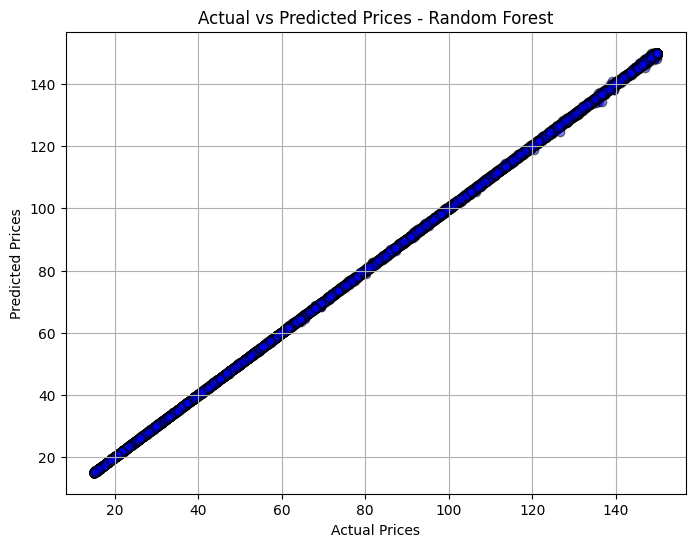

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, color='blue', edgecolor='black', alpha=0.5)
plt.title('Actual vs Predicted Prices - Random Forest')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()

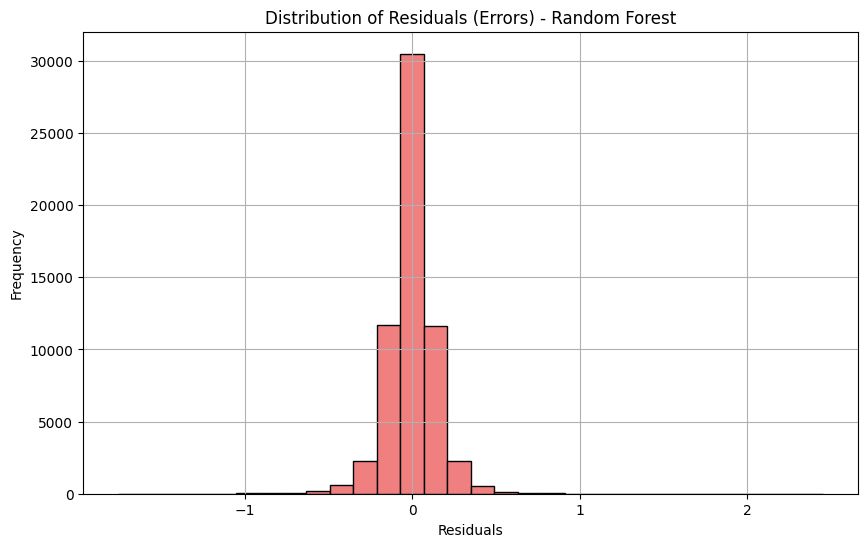

In [8]:
residuals = y_test - y_pred_rf


plt.figure(figsize=(10,6))
plt.hist(residuals, bins=30, edgecolor='black', color='lightcoral')
plt.title('Distribution of Residuals (Errors) - Random Forest')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

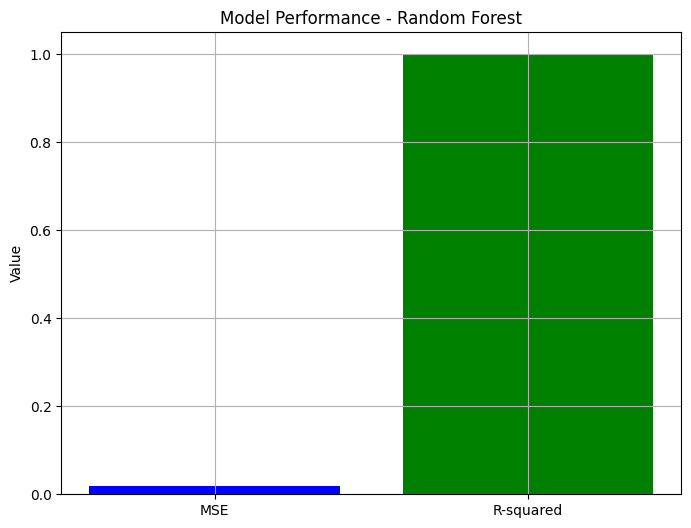

In [9]:
metrics = ['MSE', 'R-squared']
values = [mse_rf, r2_rf]

plt.figure(figsize=(8,6))
plt.bar(metrics, values, color=['blue', 'green'])
plt.title('Model Performance - Random Forest')
plt.ylabel('Value')
plt.grid(True)
plt.show()

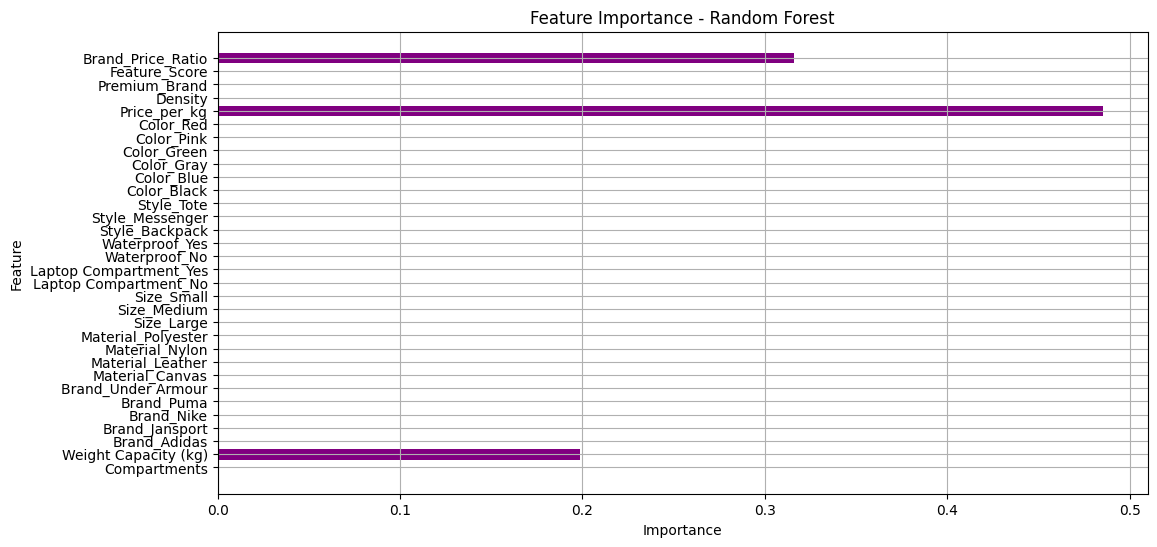

In [10]:
importances = rf_model.feature_importances_
features = X.columns

# Plot the feature importance
plt.figure(figsize=(12,6))
plt.barh(features, importances, color='purple')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

In [11]:
#Preparing Test data
X_test_data = test_data.drop(['id'], axis=1)

X_test_data[numeric_features] = numeric_imputer.transform(X_test_data[numeric_features])
X_test_data[categorical_features] = categorical_imputer.transform(X_test_data[categorical_features])

encoded_test_data = encoder.transform(X_test_data[categorical_features])
encoded_test_df = pd.DataFrame(encoded_test_data, columns=encoder.get_feature_names_out(categorical_features))

X_test_data = X_test_data.drop(categorical_features, axis=1)
X_test_data = pd.concat([X_test_data, encoded_test_df], axis=1)

# Feature engineering for the test set 
X_test_data['Price_per_kg'] = X_test_data['Weight Capacity (kg)'] / X_test_data['Weight Capacity (kg)']  # You can adapt this if needed
X_test_data['Density'] = X_test_data['Weight Capacity (kg)'] / (X_test_data['Compartments'] + 1)
X_test_data['Premium_Brand'] = X_test_data[premium_brands_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
X_test_data['Feature_Score'] = (X_test_data['Laptop Compartment_Yes'] == 1).astype(int) + \
                                (X_test_data['Waterproof_Yes'] == 1).astype(int) + \
                                (X_test_data['Style_Backpack'] == 1).astype(int)
X_test_data['Brand_Price_Ratio'] = X_test_data.apply(calculate_brand_price_ratio, axis=1)
X_test_data['Brand_Price_Ratio'] = X_test_data['Brand_Price_Ratio'].fillna(X_test_data['Brand_Price_Ratio'].mean())


predictions = rf_model.predict(X_test_data)

submission = test_data[['id']].copy()  
submission['Price'] = predictions 

submission.to_csv('/kaggle/working/submission.csv', index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!
